<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/2025_methods_mats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# research methods mats  

https://opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/

- 1 session  
- v long; idk who can edit it  
- start to finish of a model and all the things i do to validate the model  
- discuss the research methods of each step  
- talk about alternatives -- demonstrate some, but not all  

In [ ]:
!pip install catboost
!pip install optuna

<IPython.core.display.Javascript object>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 13.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import catboost as cb
import optuna as opt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import GroupKFold, KFold

<IPython.core.display.Javascript object>

## Make data for the seminar

In [ ]:
project_dir = 'drive/My Drive/nflfastR-data'

<IPython.core.display.Javascript object>

In [ ]:
years = range(2020,2025)
df = pd.DataFrame()

for year in years:
  _df = pd.read_csv(f"{project_dir}/pbp/season={year}/play_by_play_{year}.csv")
  df = pd.concat([df,_df])
df = df.reset_index(drop=True)
df.shape

<IPython.core.display.Javascript object>

/tmp/ipython-input-1606371435.py:5: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,213,214,218,219,220,222,224,226,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(f"{project_dir}/pbp/season={year}/play_by_play_{year}.csv")
/tmp/ipython-input-1606371435.py:5: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,233,234,235,236,237,238,248,249,253,254,255,260,262,263,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(f"{project_dir}/pbp/season={year}/play_by_play_{year}.csv")
/tmp/ipython-input-1606371435.py:5: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,222,224,226,243,244,245,253,254,255,260,262,263,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(f"{pro

(248530, 372)

In [ ]:
# make season-week index
df['seasonweek'] = (df['season']
                    .astype(str)
                    .add(df['week']
                         .astype(str)
                         .str
                         .zfill(2)))

df['seasonweek'] = df['seasonweek'].astype(int)

# home/away bool
df['pos_team_home'] = 0
df.loc[df['posteam']==df['home_team'], 'pos_team_home'] = 1

# eras as defined by the original nflfastR EP model
df['era'] = '1999-2001'
df.loc[df['season'].between(2002,2005), 'era'] = '2002-2005'
df.loc[df['season'].between(2006,2013), 'era'] = '2006-2013'
df.loc[df['season'].between(2014,2017), 'era'] = '2014-2017'
df.loc[df['season']>=2018, 'era'] = '2018-current'

# renaming results to "next score" values
cur_events = [
    'Punt', 'Touchdown', 'Turnover', 'Field goal',
    'Turnover on downs', 'End of half',
    'Missed field goal', 'Opp touchdown', 'Safety'
]
final_events = [
    'No Score', 'Touchdown', 'No Score',
    'Field goal', 'No Score', 'No Score', 'No Score',
    'Opp Touchdown', 'Safety'
]
df['drive_event'] = (df['fixed_drive_result']
                     .fillna('No Score')
                     .replace(cur_events,final_events))

# convert str variables into categorical variables
cols = ['defteam', 'roof', 'era', 'drive_event']
for col in cols:
  df[f'{col}_code'] = df[col].astype('category').cat.codes

# if you want to control for the head coach vs the team, coding the coach
df['pos_coach'] = df['home_coach']
df.loc[df['pos_team_home']==0, 'pos_coach'] = df.loc[df['pos_team_home']==0, 'away_coach']

# convert fg results to bool
df['fg'] = (df['field_goal_result']
            .replace(['made', 'blocked', 'missed'], [1,0,0])
            .fillna(0))

# label scoring plays (td, fg, safety)
df['scoring_play'] = df.loc[:, ['touchdown', 'fg', 'safety']].sum(axis=1)

# this gives us a text description per row
df['scoring_desc'] = df.loc[:, ['touchdown', 'fg', 'safety']].idxmax(axis=1)

# handle end of game conditions and label as "no score"
df.loc[(df['qtr'].isin([2, 4, 5]))&((df['quarter_end']==1) | (df['desc'].str.contains('END GAME')) |(df['desc'].str.contains('END QUARTER 2'))), 'scoring_desc'] = 'no_score'
df.loc[(df['scoring_play']==0) & (df['scoring_desc']!='no_score'), 'scoring_desc'] = np.nan

# subset to ep model data
model_feats = [
    'game_id', 'play_id', 'scoring_desc','posteam',
    'defteam', 'posteam_score', 'posteam_score_post',
    'defteam_score', 'defteam_score_post'
]
_df = df.loc[(df['scoring_play']==1) | (df['scoring_desc']=='no_score'), model_feats]

# feature for what team scores next (posteam or defteam)
_df['next_score_team'] = np.nan
_df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'next_score_team'] = _df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'posteam']
_df.loc[_df['defteam_score']!=_df['defteam_score_post'], 'next_score_team'] = _df.loc[_df['defteam_score']!=_df['defteam_score_post'], 'defteam']

# more engineering for what team scores next based on previous team-score engineering
_df['wtf'] = _df.loc[:, ['posteam_score', 'posteam_score_post', 'defteam_score', 'defteam_score_post']].isnull().sum(axis=1)
_df.loc[(_df['wtf']==2) & (_df['posteam_score_post']>0), 'next_score_team'] = _df.loc[(_df['wtf']==2) & (_df['posteam_score_post']>0), 'posteam']
_df.loc[(_df['wtf']==2) & (_df['defteam_score_post']>0), 'next_score_team'] = _df.loc[(_df['wtf']==2) & (_df['defteam_score_post']>0), 'defteam']
_df.loc[_df['wtf']==4, 'next_score_team'] = np.nan

# append next score team info back to original dataframe
df['next_score_desc'] = _df['scoring_desc']
df['next_score_team'] = _df['next_score_team']

# for null data, fill data with the most recent value
df.loc[:, ['next_score_team', 'next_score_desc']] = df.loc[:, ['next_score_team', 'next_score_desc']].fillna(method='bfill')

# when there's no score, explicitly set nulls
df.loc[df['scoring_desc']=='no_score', 'next_score_team'] = np.nan

# declare whether the pos team or the opp team scored (or didn't)
df['opp'] = ''
df.loc[df['posteam']!=df['next_score_team'], 'opp'] = 'opp_'
df['next_score_target'] = df['opp'].add(df['next_score_desc']).replace('opp_no_score', 'no_score')

# convert to categorical values
df['next_score_target_code'] = df['next_score_target'].astype('category').cat.codes
df.shape

<IPython.core.display.Javascript object>

/tmp/ipython-input-1910305021.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(['made', 'blocked', 'missed'], [1,0,0])
/tmp/ipython-input-1910305021.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['SF' 'SF' 'ARI' ... 'PHI' 'KC' 'KC']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  _df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'next_score_team'] = _df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'posteam']
/tmp/ipython-input-1910305021.py:85: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[:, ['next_sc

(248530, 389)

Features for model:  

- Seconds remaining in half
- Yard line
- Whether possession team is at home
- Roof type: retractable, dome, or outdoors
- Down
- Yards to go
- Era: 1999-2001 (pre-expansion), 2002-2005 (pre-CPOE), 2006-2013 (pre-LOB rules change), 2014-2017, 2018 and beyond
- Timeouts remaining for each team

In [ ]:
context_feats = [
    'play_id', 'game_id', 'home_team', 'away_team',
    'season_type', 'week', 'posteam', 'posteam_type',
    'defteam', 'desc', 'play_type', 'passer_player_id',
    'passer_player_name', 'passing_yards',
    'receiver_player_id', 'receiver_player_name',
    'receiving_yards', 'rusher_player_id',
    'rusher_player_name', 'rushing_yards','no_score_prob',
    'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob',
    'fg_prob', 'safety_prob', 'td_prob', 'extra_point_prob',
    'two_point_conversion_prob', 'ep', 'epa', 'wp', 'def_wp',
    'home_wp', 'away_wp', 'wpa', 'vegas_wpa',
    'vegas_home_wpa', 'home_wp_post', 'away_wp_post',
    'vegas_wp', 'vegas_home_wp', 'roof', 'era',
    'next_score_target'
]

model_feats = [
    'season', 'half_seconds_remaining', 'yardline_100',
    'pos_team_home', 'roof_code', 'down', 'ydstogo',
    'era_code', 'posteam_timeouts_remaining',
    'defteam_timeouts_remaining'
]

target = 'next_score_target_code'

<IPython.core.display.Javascript object>

In [ ]:
df.loc[:, context_feats+model_feats+[target]].to_csv('drive/My Drive/2025-research-methods-seminar/df.csv', index=False)

<IPython.core.display.Javascript object>

## making the model  

The session starts here  
- why methods  
- description of the model we're replicating  
- why replicate  
- feature selection  
- hyperparam tuning  

Why methods  

- asking good questions requires defending your methods  
- good methods help clearly define the problem (asking good questions)  
- research methods make you sound cool  
- if you aren't methodical what are you?  
- too much EDA can be frivolous  
- perfection is unquestionable  
- good methods aren't perfect, but they are better than no methods (or bad methods)  
- solid methods avoid silly mistakes; prevents introduction of biases    
- scientific methods = research methods  
- good methods = time saving; money saving  
- methods should help with _next_ project iterations too  
- good methods = succinct explanations for why  
- good methods are reproducible (think: recipes)  


Model rundown  
- EP model from nflverse / nflfastr / open source football  
- Expected points given field position and game state  
- expected points = probability of scoring and also probability of opponent getting the ball and also scoring, converted into points (points * probability = expected points)  
- field position can give us probability of different events (fg, touchdown, safety, no score -- also opponent fg, opponent td, opponent safety)  


why replicate  

- good methods can be replicated  
- we can investigate why certain methods were selected (based off the initial research paper + blog post)  
- we can compare our methods to theirs (not everything will be the same)  
- we can discuss introducing new methods (new features, updates to the model, etc)  
- we can borrow methods and use them elsewhere (are these methods suitable for other problems?)  


features in this model  
Features for model:  

- Seconds remaining in half
- Yard line
- Whether possession team is at home
- Roof type: retractable, dome, or outdoors
- Down
- Yards to go
- Era: 1999-2001 (pre-expansion), 2002-2005 (pre-CPOE), 2006-2013 (pre-LOB rules change), 2014-2017, 2018 and beyond
- Timeouts remaining for each team

why do we care about...  
- seconds in half: changes pace, decision making; desperation; time to generate points; fatigue  
- yard line: passive vs aggressive play calling; risk aversion; scoring probability  
- home field: affects the player (sleeping at home vs in a hotel); advantages of home (closer to training facilities, routine is known); familiarity; home field biases (refs, crowd, "team advantages"); disruption of typical plays; home field advantage does have some statistical power (see: research + vegas odds)  
- roof type: roof type begats ground type (real grass, fake grass); weather (cold, rain, hot); day vs night vs neutral; wind; air density (for punts, field goals, long throws)  
- down / distance: play calling  
- time outs: play calling, ability to rest; ability to subtitute  
- season: different rules; different players (some players are retiring, some players are rookies); strategic developments (some eras are more run-heavy, some eras are more pass-heavy); the scoring environment can be different  
- most important thing: scoring environment can be different -- when you're asking the question "what's the probability of scoring? what's the expected points given my field position?" these are questions related to the scoring environment -- so all aspects (or as many as possible) of the scoring environment should be accounted for



In [ ]:
project_dir = 'drive/My Drive/2025-research-methods-seminar'

<IPython.core.display.Javascript object>

In [ ]:
context_feats = [
    'play_id', 'game_id', 'home_team', 'away_team',
    'season_type', 'week', 'posteam', 'posteam_type',
    'defteam', 'desc', 'play_type', 'passer_player_id',
    'passer_player_name', 'passing_yards',
    'receiver_player_id', 'receiver_player_name',
    'receiving_yards', 'rusher_player_id',
    'rusher_player_name', 'rushing_yards','no_score_prob',
    'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob',
    'fg_prob', 'safety_prob', 'td_prob', 'extra_point_prob',
    'two_point_conversion_prob', 'ep', 'epa', 'wp', 'def_wp',
    'home_wp', 'away_wp', 'wpa', 'vegas_wpa',
    'vegas_home_wpa', 'home_wp_post', 'away_wp_post',
    'vegas_wp', 'vegas_home_wp', 'roof', 'era',
    'next_score_target'
]

model_feats = [
    'season', 'half_seconds_remaining', 'yardline_100',
    'pos_team_home', 'roof_code', 'down', 'ydstogo',
    'era_code', 'posteam_timeouts_remaining',
    'defteam_timeouts_remaining'
]

target = 'next_score_target_code'

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv(f'{project_dir}/df.csv')
df.shape

<IPython.core.display.Javascript object>

(248530, 56)

In [ ]:
df['next_score_target'] = df['next_score_target'].replace({'touchdown':'td', 'opp_touchdown':'opp_td'})
col_map = df.loc[:, ['next_score_target_code','next_score_target']].drop_duplicates()
col_map['next_score_target'] = col_map['next_score_target'].add('_rep_prob')
col_map = col_map.set_index('next_score_target_code').to_dict()['next_score_target']

model_data = df.loc[df['season']<2024].dropna(subset=model_feats+[target])
test_data = df.loc[df['season']==2024].dropna(subset=model_feats+[target])

model = cb.CatBoostClassifier(verbose=False)
model.fit(model_data.loc[:, model_feats], model_data[target])
preds = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), index=test_data.index).rename(columns=col_map)
test_data = pd.concat([test_data, preds], axis=1)

<IPython.core.display.Javascript object>

In [ ]:
new_cols = [x for x in test_data.columns.values if 'rep_prob' in x]
old_cols = [x for x in test_data.columns.values if '_prob' in x and 'rep_' not in x]

test_data.loc[:, old_cols+new_cols].head()

<IPython.core.display.Javascript object>

,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,fg_rep_prob,no_score_rep_prob,opp_fg_rep_prob,opp_safety_rep_prob,opp_td_rep_prob,safety_rep_prob,td_rep_prob
199040,0.004585,0.140649,0.003159,0.260660,0.209893,0.003228,0.377827,0.0,0.0,0.252226,0.004759,0.129199,0.014562,0.251178,0.000541,0.347536
199041,0.004817,0.142571,0.002405,0.270632,0.220688,0.003977,0.354910,0.0,0.0,0.301100,0.009493,0.165724,0.011191,0.203885,0.000854,0.307752
199042,0.004927,0.080094,0.001128,0.144228,0.314572,0.004124,0.450927,0.0,0.0,0.387669,0.002135,0.073230,0.005703,0.110997,0.000418,0.419848
199043,0.003781,0.059722,0.000869,0.097663,0.344726,0.002350,0.490889,0.0,0.0,0.384575,0.000867,0.026692,0.000115,0.062548,0.000350,0.524853
199044,0.003754,0.053687,0.000824,0.097134,0.370147,0.001603,0.472850,0.0,0.0,0.480692,0.002095,0.037649,0.000913,0.091404,0.000271,0.386977


are we replicating?  
statistically, you can use log loss, RMSE, MAE, or any custom loss or accuracy functions to know whether predictions are "close" to the actual. however, we don't know if those are the _best_ possible predictions. so it's important to weigh accuracy of predictions against "baseline" models.  

you can always have some form of a baseline model  
- the previous model that everyone uses? that's the baseline!  
- if you don't have a baseline model that everyone uses, there are several alternatives: mean prediction, rolling mean predictions, linear models  
- in most cases, there _is_ a model everyone uses -- a lot of the time, it's a mean/median/quantile.

<IPython.core.display.Javascript object>

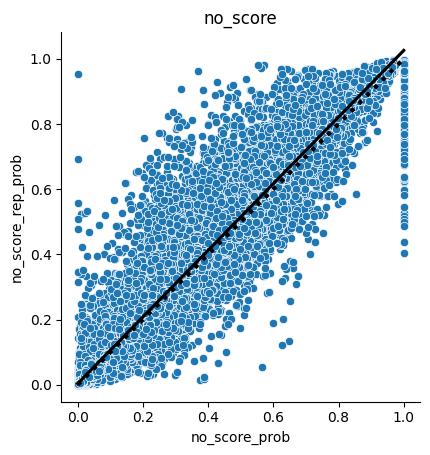

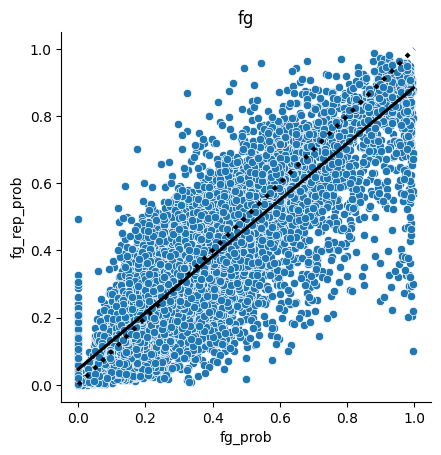

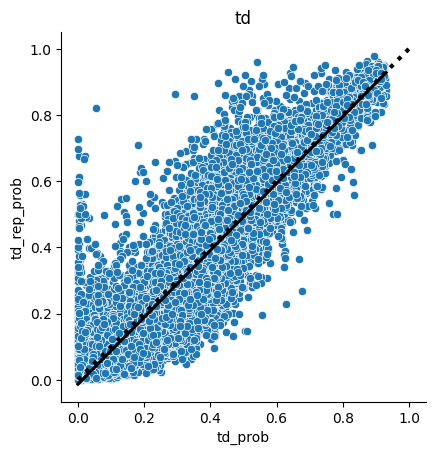

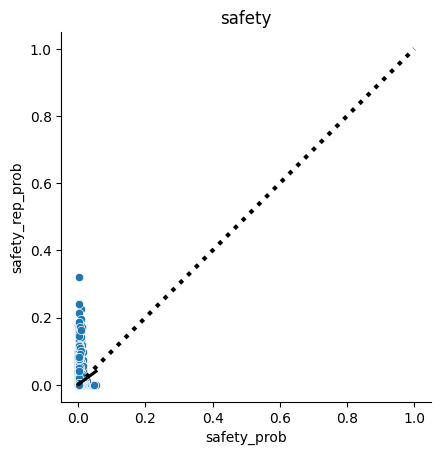

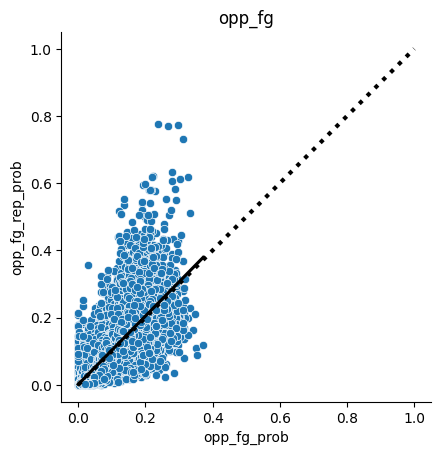

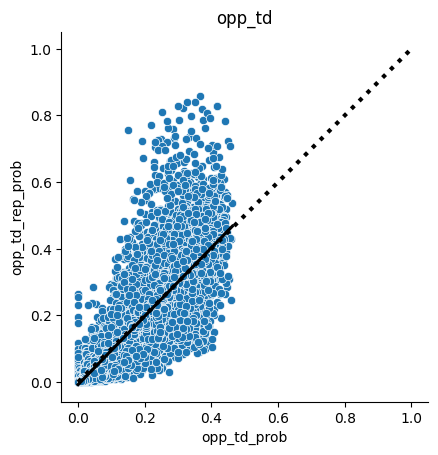

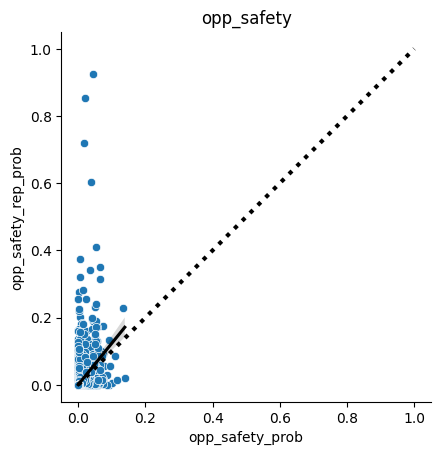

In [ ]:
cols = [
    'no_score', 'fg', 'td', 'safety', 'opp_fg', 'opp_td', 'opp_safety'
]

for col in cols:
  sns.scatterplot(data=test_data, x=f'{col}_prob', y=f'{col}_rep_prob')
  sns.regplot(data=test_data, x=f'{col}_prob', y=f'{col}_rep_prob', scatter=False, color='k')
  plt.plot([0,1],[0,1],'k:',lw=3)
  plt.gca().set_aspect('equal')
  plt.title(col)
  sns.despine()
  plt.show()

In [ ]:
rep_loss = log_loss(test_data[target], test_data.loc[:, new_cols])
og_loss = log_loss(test_data[target], test_data.loc[:, [x.replace('rep_','') for x in new_cols]])

og_loss, rep_loss

<IPython.core.display.Javascript object>

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


(1.2982745743950659, 1.3283117712965837)

new model is still worse than the original model, why?  

- old model uses hyperparameter tuning  
- old model is trained on more data  

both are ways to increase prediction accuracy. we won't use more data in this session but we will tune.  

old model tuning params (xgboost in R)  
```r  
nrounds <- 525
params <-
  list(
    booster = "gbtree",
    objective = "multi:softprob",
    eval_metric = c("mlogloss"),
    num_class = 7,
    eta = 0.025,
    gamma = 1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    max_depth = 5,
    min_child_weight = 1
  )
```
if you are not familiar with hyperparameter tuning, you should learn more about it on your own. i am not going to teach about what hear hyperparameter does -- a lot of it is really hardcore stats.  

if you know a little about hyperparameter tuning (i.e. gridsearch, randomizesearchCV, hyperopt, optuna, etc) but don't have clear methods around hyperparam tuning, then this is for you!

https://x.com/rasbt/status/1615737492476395522?t=T4nVg55ts4277EMCxWKEkw

https://arxiv.org/pdf/1811.12808

https://github.com/Raschka-research-group/hotspotter/blob/main/experiments/figure-overfitting-gbm/1_histgbm_overtuned-large-hparam.ipynb

additional tuning methods papers

https://arxiv.org/pdf/2007.07588


some important tuning tips from an old:  
- depending on your dataset, some parameters will affect your model accuracy more than others  
- usually the "biggest" tuning parameters are learning rate, iterations, and depth  
- similar to features, each parameter you adjust influences how the features in your model interact between each other -- introducing too many parameters at a time can give false positives  
- in many ways, you are never "done" with tuning (just like you are never done collecting data and training on new data) -- it's up to you to determine your own benchmarks for model acceptance (i.e. beating a baseline model, the newest prod model, etc)  
- if i'm tuning manually, i keep a tuning journal/log  

log loss | eta | iterations | depth | gamma  
--- | --- | --- | --- | ---  
0.3 | 0.3 | 100 | 5 | 1  
0.28 | 0.1 | 100 | 5 | 1  
0.27 | 0.3 | 500 | 5 | 1  
0.21 | 0.1 | 500 | 5 | 1  
0.11 | 0.1 | 500 | 7 | 1  
0.09 | 0.1 | 500 | 9 | 1  
0.009 | 0.1 | 500 | 9 | 2  

- if i'm tuning using optuna, i still like keeping a log of things i'm trying  

log loss | eta | iterations | depth | gamma  
--- | --- | --- | --- | ---  
0.3 | np.arange(0.1,0.5,0.01) | range(100,500) | range(5,10) | range(1,10)  
0.24 | np.arange(0.01,0.5,0.01) | range(100,1000) | range(5,10) | range(1,10)  
0.12 | np.arange(0.01,0.5,0.01) | range(100,5000) | range(5,10) | range(1,10)   

- some of these packages may do this for you already (optuna does!)  



In [ ]:
tuned_col_map = {k:v.replace('_rep_prob','_rep_tuned_prob') for k,v in col_map.items()}
# no gamma, subsample
params = {
    'classes_count':model_data[target].unique().shape[0],
    'sampling_frequency':'PerTree',
    'max_depth':5,
    'min_data_in_leaf':1,
    'verbose':False
}

model = cb.CatBoostClassifier(**params)
model.fit(model_data.loc[:, model_feats], model_data[target])
preds = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), index=test_data.index).rename(columns=tuned_col_map)
test_data = pd.concat([test_data, preds], axis=1)
new_cols = [x for x in test_data.columns.values if 'rep_tuned_prob' in x]

rep_tuned_loss = log_loss(test_data[target], test_data.loc[:, new_cols])

og_loss, rep_loss, rep_tuned_loss

<IPython.core.display.Javascript object>

(1.2982745743950659, 1.3283117712965837, 1.3136594248890279)

<IPython.core.display.Javascript object>

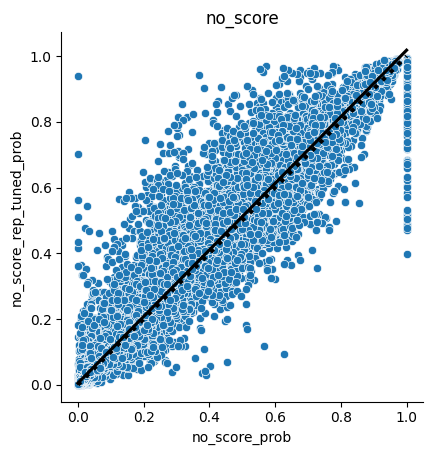

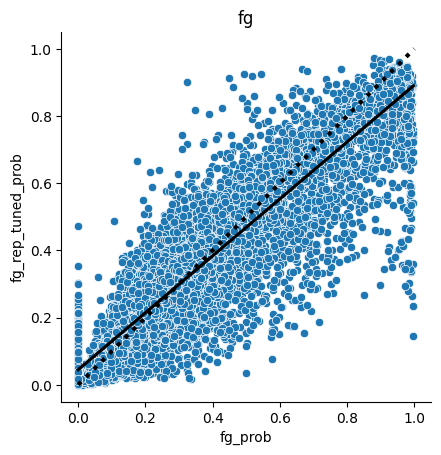

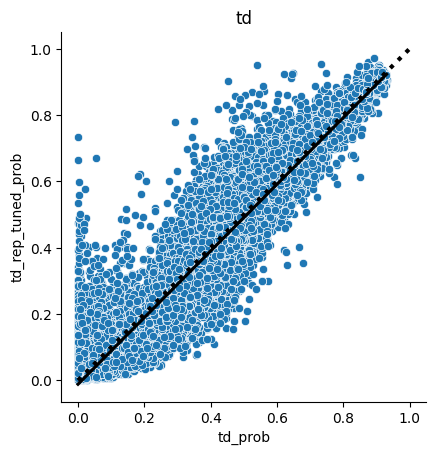

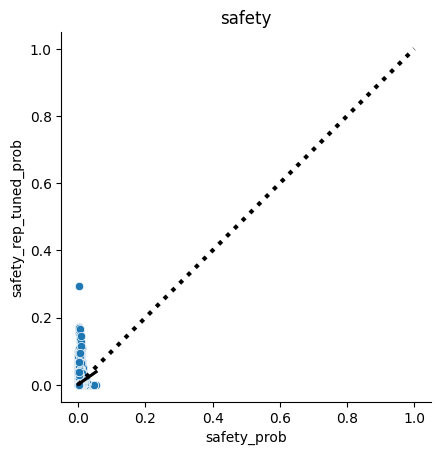

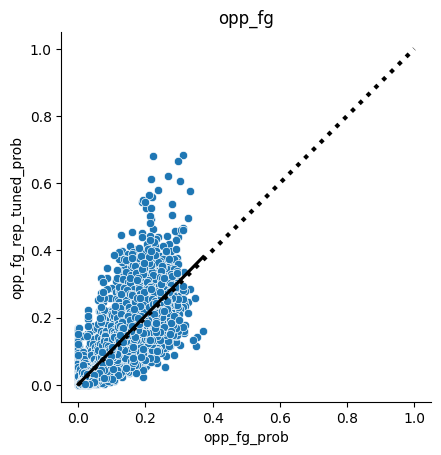

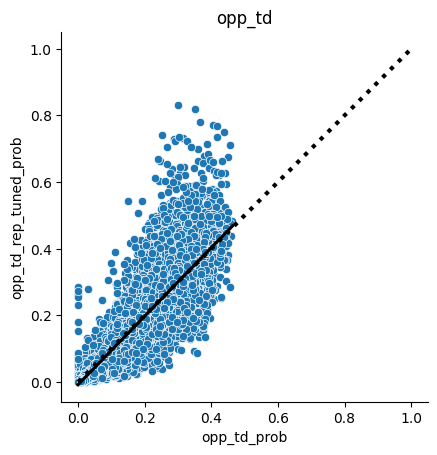

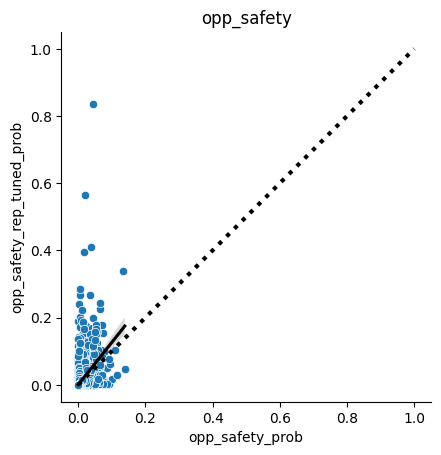

In [ ]:
cols = [
    'no_score', 'fg', 'td', 'safety', 'opp_fg', 'opp_td', 'opp_safety'
]

for col in cols:
  sns.scatterplot(data=test_data, x=f'{col}_prob', y=f'{col}_rep_tuned_prob')
  sns.regplot(data=test_data, x=f'{col}_prob', y=f'{col}_rep_tuned_prob', scatter=False, color='k')
  plt.plot([0,1],[0,1],'k:',lw=3)
  plt.gca().set_aspect('equal')
  plt.title(col)
  sns.despine()
  plt.show()

Using the parameters from the xgb model, the catboost model did improve (which makes sense) but the gains were modest. we could iterate over this manually (which would take a long time) or we can utilize optuna to do this for us (which will do it in methodolgically sound ways).  

won't go into how optuna works but conceptually:  
- in an exhaustive grid search, you have to define all of the values you want to search over, which can be a lot and early stopping may prevent searching over parameter interactions that would have been model improving  
- in a randomized search, you still have to define your entire search space but you _might_ have better success randomly finding parameter interactions in your search space
- some packages (hyperopt, optuna, etc) allow for more efficient searching over a parameter space due to optimized pruning techniques. This is where some parameter interactions are clearly poor at improving model performance, and those interactions are pruned or downweighted as possible combinations in the grid search space.  



In [ ]:
def tune(trial):
  params = {
      'classes_count':model_data[target].unique().shape[0],
      'sampling_frequency':'PerTree',
      'max_depth':trial.suggest_int('max_depth',1,7),
      'min_data_in_leaf':trial.suggest_int('min_data_in_leaf',1,4),
      'iterations':trial.suggest_int('iterations',300,1000),
      'verbose':False,
      'eta':trial.suggest_float('eta',0.01,0.5),
      'auto_class_weights':trial.suggest_categorical('auto_class_weights',['None','Balanced', 'SqrtBalanced']),
      'bagging_temperature':trial.suggest_float('bagging_temperature',0,5)
  }
  model = cb.CatBoostClassifier(**params)
  model.fit(model_data.loc[:, model_feats], model_data[target])
  preds = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), index=test_data.index).rename(columns=tuned_col_map)
  rep_tuned_loss = log_loss(test_data[target], preds)
  return rep_tuned_loss


<IPython.core.display.Javascript object>

In [ ]:
study = opt.create_study(direction='minimize')
study.optimize(tune, n_trials=100)
study.best_params

```
{'max_depth': 3,
 'min_data_in_leaf': 1,
 'iterations': 683,
 'eta': 0.02990878853506556,
 'auto_class_weights': 'None',
 'bagging_temperature': 0.4188267362773233}

 ```

In [ ]:
test_data = test_data.drop(new_cols,axis=1)
tuned_col_map = {k:v.replace('_rep_prob','_rep_tuned_prob') for k,v in col_map.items()}
params = {
    'sampling_frequency':'PerTree',
    'classes_count':model_data[target].unique().shape[0],
    'verbose':False,
    'max_depth': 3,
    'min_data_in_leaf': 1,
    'iterations': 683,
    'eta': 0.02990878853506556,
    'auto_class_weights': 'None',
    'bagging_temperature': 0.4188267362773233
}

model = cb.CatBoostClassifier(**params)
model.fit(model_data.loc[:, model_feats], model_data[target])
preds = pd.DataFrame(model.predict_proba(test_data.loc[:, model_feats]), index=test_data.index).rename(columns=tuned_col_map)
test_data = pd.concat([test_data, preds], axis=1)
new_cols = [x for x in test_data.columns.values if 'rep_tuned_prob' in x]

rep_tuned_loss = log_loss(test_data[target], test_data.loc[:, new_cols])

og_loss, rep_loss, rep_tuned_loss

<IPython.core.display.Javascript object>

(1.2982745743950659, 1.3283117712965837, 1.2894640025291553)

In [ ]:
event_values = {
    'fg_rep_tuned_prob':3,
    'no_score_rep_tuned_prob':0,
    'opp_fg_rep_tuned_prob':-3,
    'opp_safety_rep_tuned_prob':-2,
    'opp_td_rep_tuned_prob':-7,
    'safety_rep_tuned_prob':2,
    'td_rep_tuned_prob':7
}

<IPython.core.display.Javascript object>

In [ ]:
ep_cols = []
for k,v in event_values.items():
  ep_cols.append(f'_{k}')
  test_data[f'_{k}'] = test_data[k].mul(v)
test_data['ep_rep'] = test_data.loc[:, ep_cols].sum(axis=1)
test_data = test_data.drop(ep_cols,axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

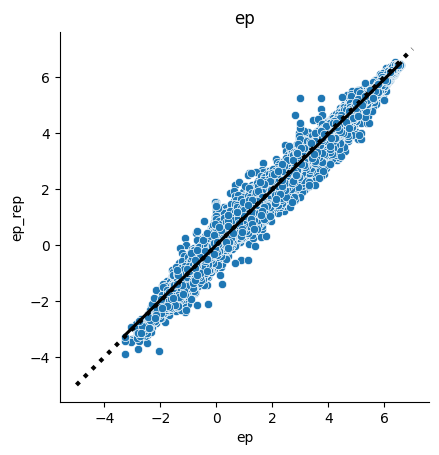

In [ ]:
sns.scatterplot(data=test_data, x='ep', y='ep_rep')
sns.regplot(data=test_data, x='ep', y='ep_rep', scatter=False, color='k')
plt.plot([-5,7],[-5,7],'k:',lw=3)
plt.gca().set_aspect('equal')
plt.title('ep')
sns.despine()
plt.show()

In [ ]:
test_data['ep_diff'] = test_data['ep'].sub(test_data['ep_rep'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

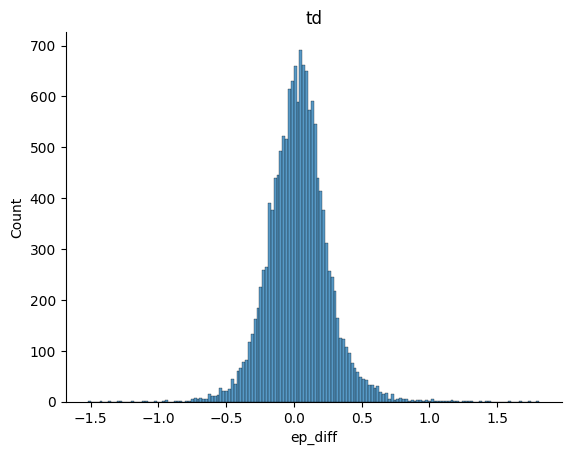

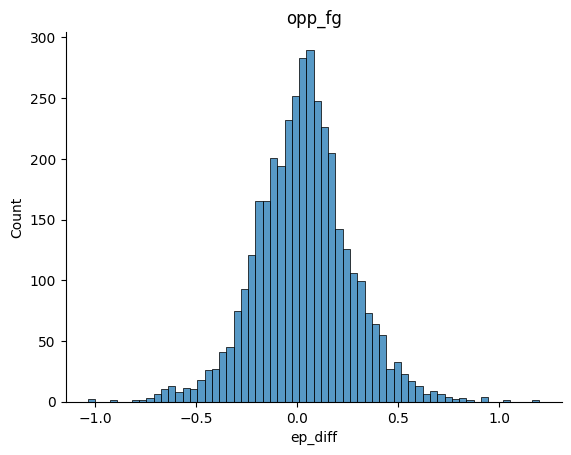

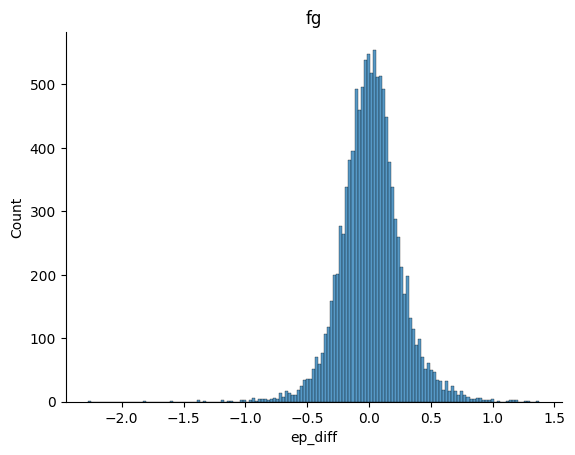

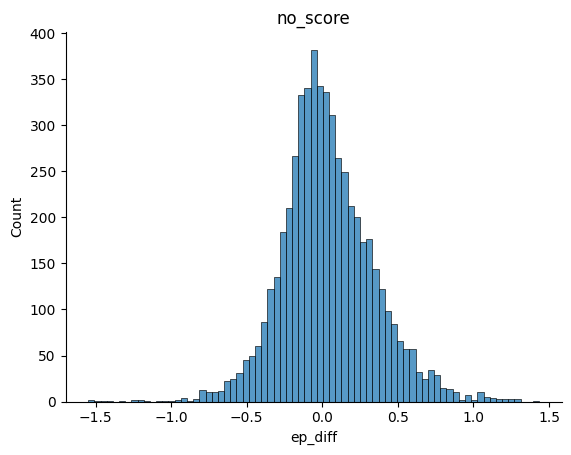

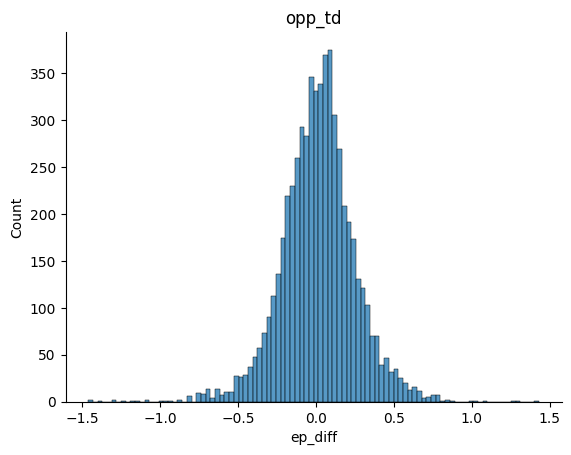

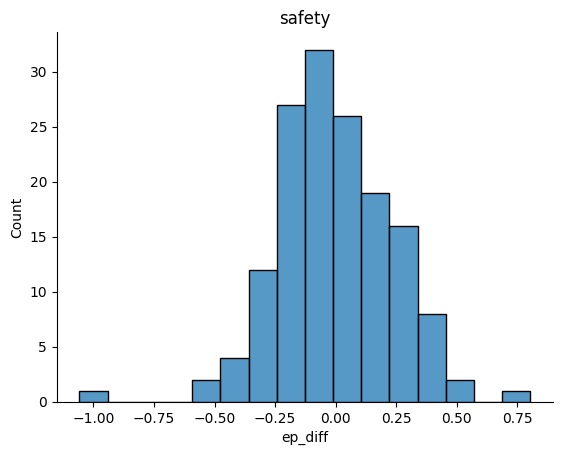

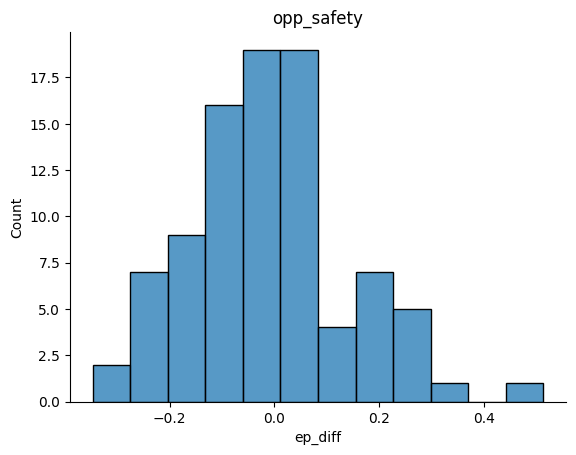

In [ ]:
for y in test_data['next_score_target'].unique():
  df_plt = test_data.loc[test_data['next_score_target']==y, 'ep_diff']
  sns.histplot(data=df_plt)
  sns.despine()
  plt.title(y)
  plt.show()

In [ ]:
df_agg = test_data.loc[:, ['passer_player_name', 'ep','ep_rep','ep_diff']].groupby(['passer_player_name'], as_index=False).sum()
df_agg.sort_values('ep_diff').head(20)

<IPython.core.display.Javascript object>

,passer_player_name,ep,ep_rep,ep_diff
26,D.Lock,326.520353,335.047231,-8.526878
107,T.Tagovailoa,919.912203,924.023589,-4.111386
17,C.Stroud,1286.068308,1289.011120,-2.942812
81,M.Willis,114.287364,117.161381,-2.874017
97,T.Boyle,109.528600,112.276831,-2.748231
79,M.Trubisky,37.460116,39.759486,-2.299370
106,T.McKee,105.223956,107.336654,-2.112698
91,S.Howell,25.542864,27.179015,-1.636152
49,J.Garoppolo,113.247864,114.819607,-1.571743
18,C.Sutton,3.915977,5.016113,-1.100136


- parameter tuning acceptence
- model differences (using your baseline model)  
- can you explain the differences? this requires domain expertise usually  
- does it pass "face validity" checks? does the order of a list make sense? if not, why?  
